In [1]:
root_path = "data/"

In [2]:
# import modules
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm.notebook as tq
import csv
import pickle # for saving results and loading them

# Functions

In [3]:
def DCSBMentropy(A, g):
  '''
  Input: 
    - adjacency matrix A of numpy sparse matrix type
    - g is a vector of partitions, integers
  Output:
    - h entropies np array
    - p value
  '''
  K = np.max(g) + 1
  e = np.zeros((K, K), dtype=np.double)
  for i in range(K):
    for j in range(K):
      e[i, j] = np.sum(A[g == i][:, g == j])
  m = np.sum(e, axis=1)
  e_sum = np.sum(m)
  for i in range(K):
    for j in range(K):
      e[i, j] /= m[i] * m[j]
  k = np.sum(A, axis=0)
  p = np.matmul(k.T, k) / e_sum
  p *= e[g][:, g]
  pp = np.triu(p)
  pp = pp[pp > 0]
  b = np.size(pp)
  h = 0.5 * ((b-1) * math.log(2 * math.pi * math.e * e_sum) + np.sum(np.log(pp)))
  return h, p

def BESTest(A, g, N = 10000):
  '''
  Input:
    - adjacency matrix A of numpy sparse matrix type
    - g is a vector of partitions, integers
    - N number of samples
  Output:
    - p-value
  '''
  h = np.zeros(shape = (N, ), dtype=np.double)
  h_partition, _ = DCSBMentropy(A,g);
  for i in tq.tqdm(range(N)):
    permuted = np.copy(g)
    np.random.shuffle(permuted)
    h[i], _ = DCSBMentropy(A, permuted)
  p = np.sum(h <= h_partition) / N
  return p

def BESTest_confidence(A, g, N = 10000, n_conf = 30):
  pvals = np.array([BESTest(A, g, N) for _ in tq.tqdm(range(n_conf))])
  return np.mean(pvals), np.std(pvals)

def save_obj(obj, name ):
   with open(name + '.pkl', 'wb') as f:
       pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Create Reciprocal Matrix

In [4]:
# Load directed graph
g_directed = nx.read_graphml(root_path + "net_dir_with_attr.graphml")

In [5]:
# Create undirected adj matrix with only reciprocal edges
g_recipr = g_directed.to_undirected(reciprocal=True)
print(g_recipr.number_of_nodes())
print(g_recipr.number_of_edges())
# Create adj matrix
mat_recipr = nx.adjacency_matrix(g_recipr)
polit_recip = mat_recipr.todense()

1207
14302


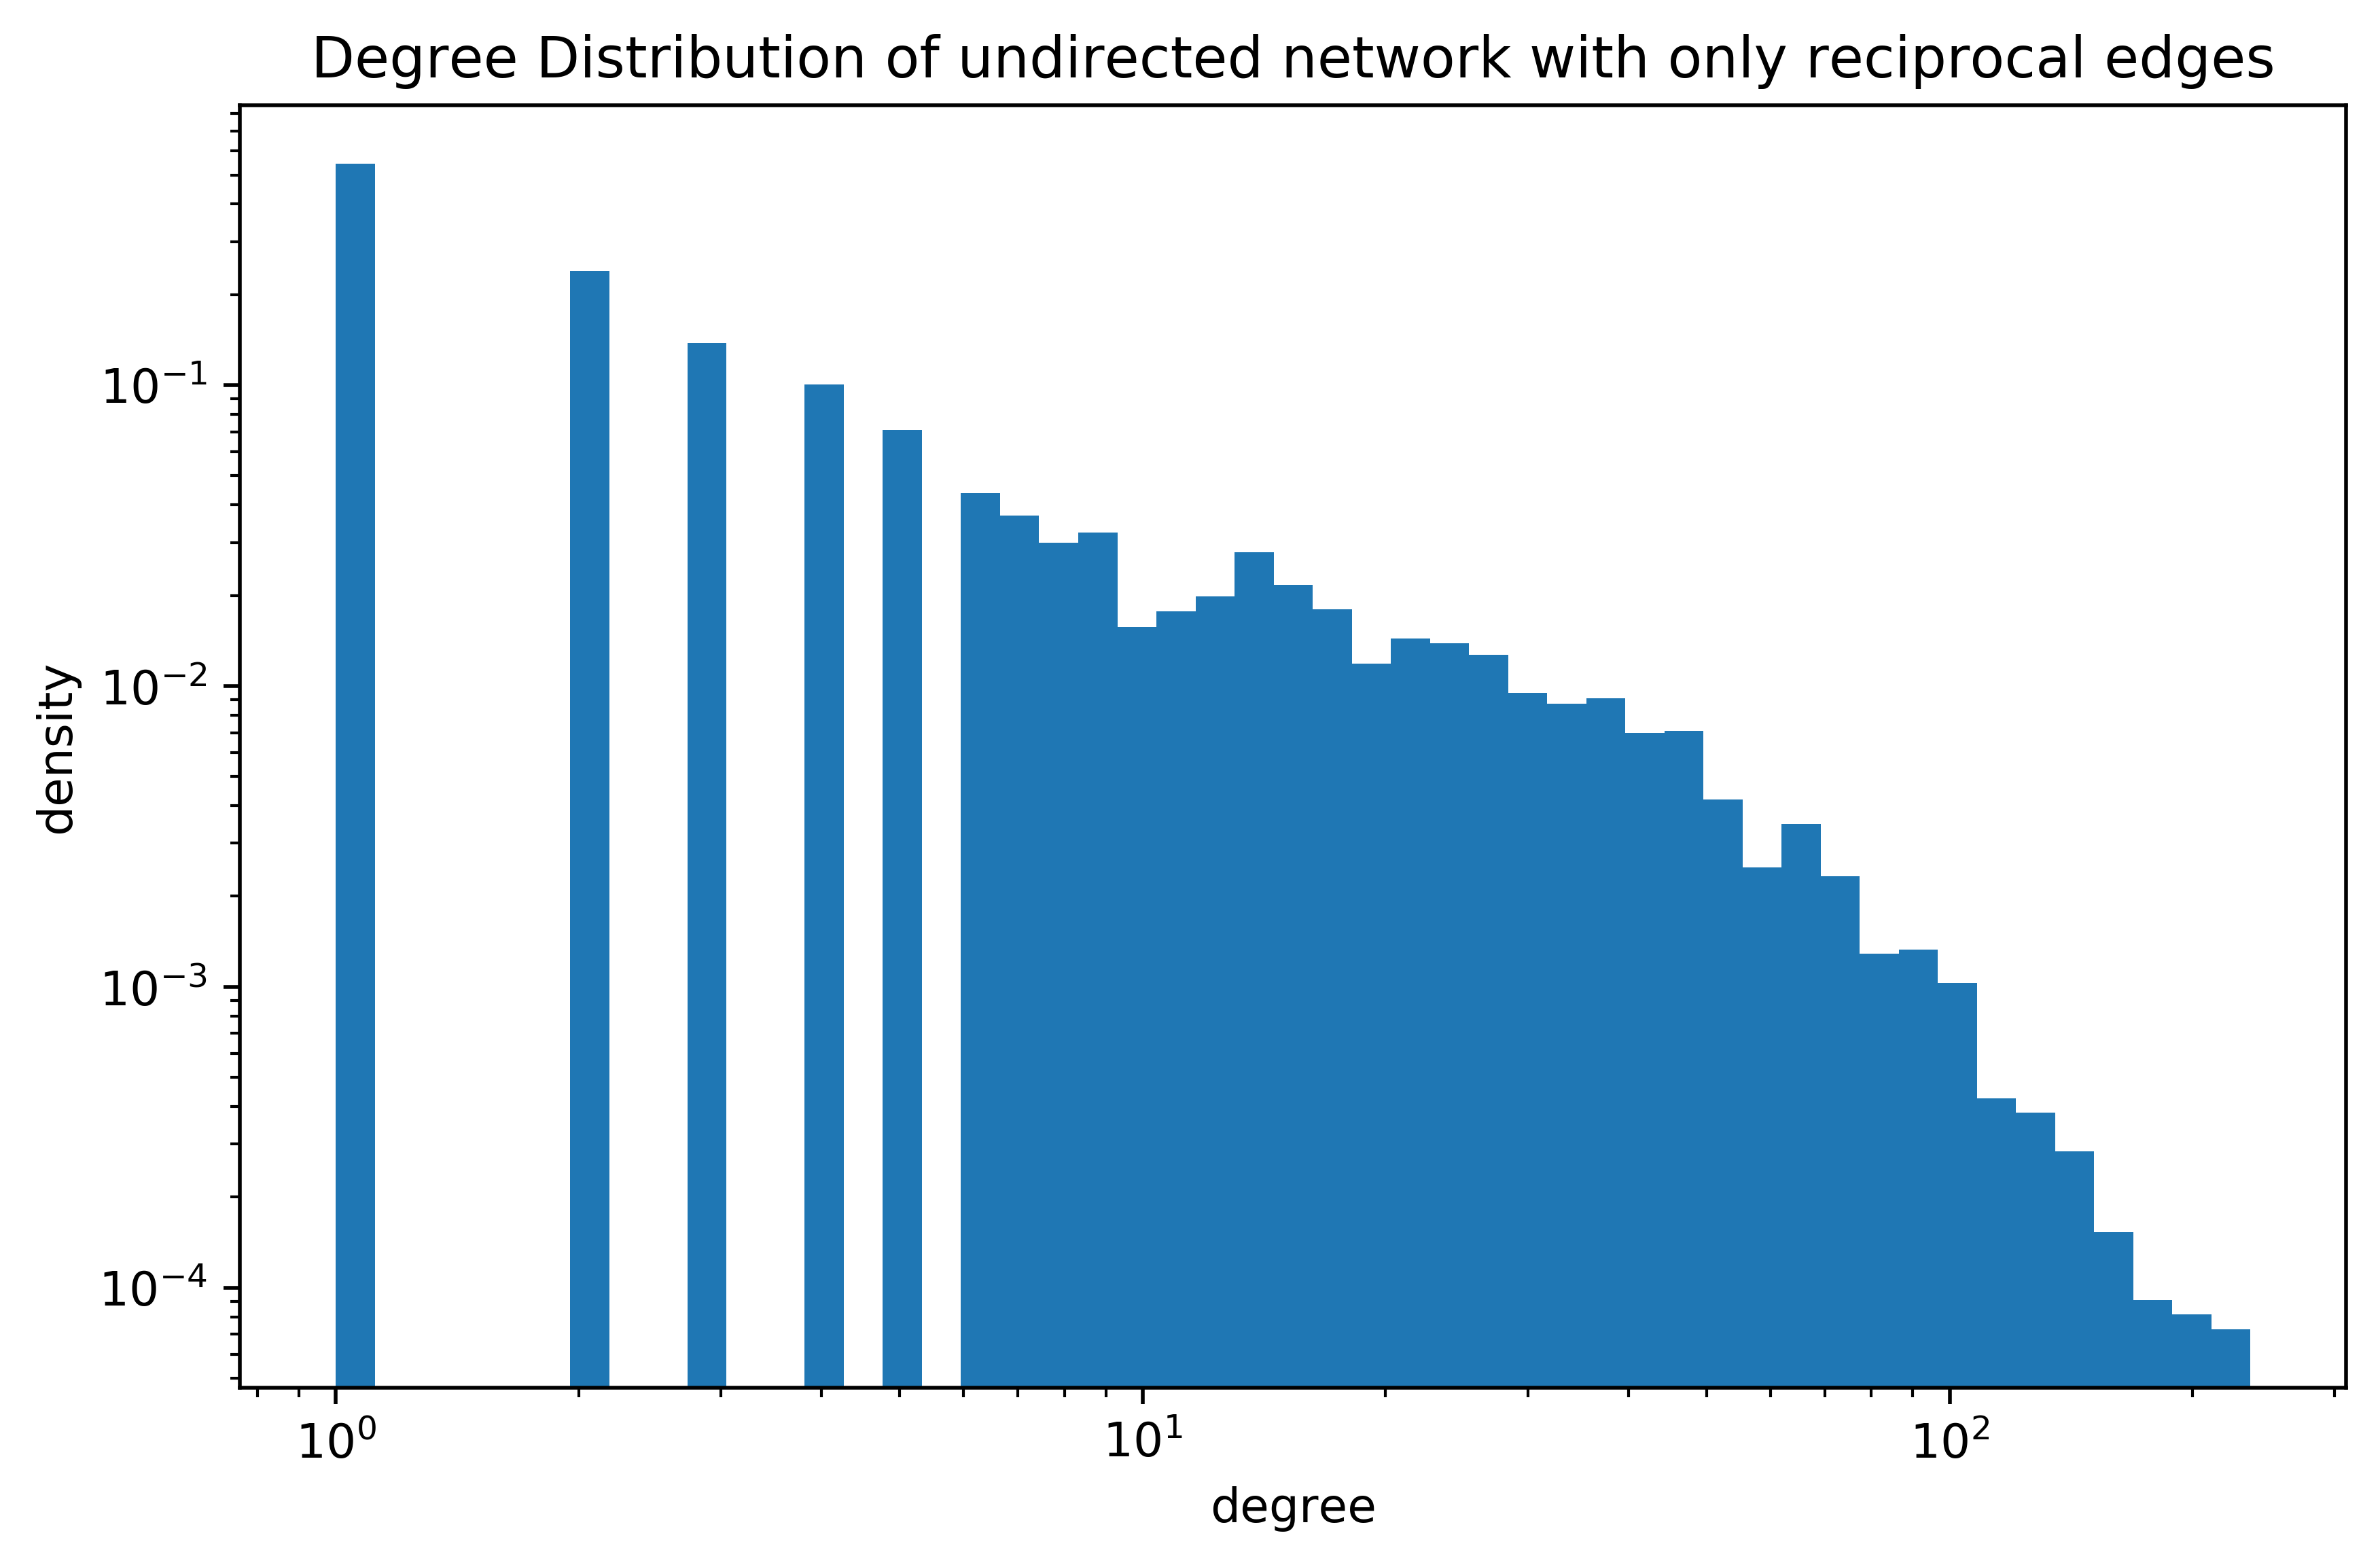

In [10]:
# degree distribution of reciprocal network
plt.figure(figsize=(8, 5), dpi = 500)
degrees_recip = g_recipr.degree()
degrees_list_recip = [ degrees_recip[i] for i in g_recipr.nodes()]
log_bin_recip = np.logspace(np.log10(min(degrees_list_recip)+1),np.log10(max(degrees_list_recip)), 50)
plt.hist(degrees_list_recip,bins = log_bin_recip, density = True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('degree')
plt.ylabel('density')
plt.title("Degree Distribution of undirected network with only reciprocal edges")
plt.show()

## Create Partitions of Metadata


In [6]:
# get dictionary with node attributes
attr_recip_party = nx.get_node_attributes(g_recipr, 'party_short')
attr_recip_gender = nx.get_node_attributes(g_recipr, 'gender')
attr_recip_canton = nx.get_node_attributes(g_recipr, 'canton')
attr_recip_incumbent = nx.get_node_attributes(g_recipr, 'incumbent')
attr_recip_year = nx.get_node_attributes(g_recipr, 'year_of_birth')

attr_recip_age = [year for year in attr_recip_year.values()]
# min 19, max 75

attr_recip_age_group = []
for i in range(len(attr_recip_age)):
  if (attr_recip_age[i] <= 1945):
    group = 0
  elif (attr_recip_age[i] > 1945 and attr_recip_age[i] <= 1964):
    group = 1
  elif (attr_recip_age[i] > 1964 and attr_recip_age[i] <= 1976):
    group = 2
  elif (attr_recip_age[i] > 1976 and attr_recip_age[i] <= 1995):
    group = 3
  else:
    group = 4
  attr_recip_age_group.append(group)

indices_recip_age = np.array(attr_recip_age_group, dtype = "int64")

# change dictionary values to vectors of integers
  # party
values_recip_party = np.array(list(attr_recip_party.values()))
vals_recip_party, indices_recip_party = np.unique(values_recip_party, return_inverse=True)
indices_recip_party = indices_recip_party.astype(dtype = "int64")

  # gender
values_recip_gender = np.array(list(attr_recip_gender.values()))
vals_recip_gender, indices_recip_gender = np.unique(values_recip_gender, return_inverse=True)
indices_recip_gender = indices_recip_gender.astype(dtype = "int64")

  # canton
values_recip_canton = np.array(list(attr_recip_canton.values()))
vals_recip_canton, indices_recip_canton = np.unique(values_recip_canton, return_inverse=True)
indices_recip_canton = indices_recip_canton.astype(dtype = "int64")

  # incumbent
values_recip_incumbent = np.array(list(attr_recip_incumbent.values()))
vals_recip_incumbent, indices_recip_incumbent = np.unique(values_recip_incumbent, return_inverse=True)
indices_recip_incumbent = indices_recip_incumbent.astype(dtype = "int64")

# Array of all attributes
polit_recip_attributes = [indices_recip_age, indices_recip_party, indices_recip_incumbent, indices_recip_gender, indices_recip_canton]

# Prepare arrays for storing
p_recip_values = np.zeros(5, dtype=np.float64)
sd_recip_values = np.zeros(5, dtype=np.float64)

In [7]:
# Calculations
for i, attribute in tq.tqdm(enumerate(polit_recip_attributes)):
  p_recip_values[i], sd_recip_values[i] = BESTest_confidence(polit_recip, attribute, N=100, n_conf=3) # remove the N and n_conf for the full calculations

/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [8]:
# Print the results
print("Reciprocal edges")
for i in range(len(polit_recip_attributes)):
  print("p-value: " + str(p_recip_values[i]) + "; " + str(sd_recip_values[i]) + ";")

Reciprocal edges
p-value: 0.06; 0.03741657386773942;
p-value: 0.5966666666666667; 0.04496912521077347;
p-value: 0.12333333333333334; 0.026246692913372706;
p-value: 1.0; 0.0;
p-value: 0.2833333333333333; 0.05249338582674541;


In [9]:
# Save the results
save_obj(p_recip_values, "out/p_values_recip")
save_obj(sd_recip_values, "out/sd_values_recip")